<a href="https://colab.research.google.com/github/akarshn95/Yelp_Reviews_Sentiment_Analysis/blob/master/Yelp_Review_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Yelp Reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('/content/drive/My Drive/Kaggle/yelp_reviews.csv')

## Exploratory Data Analysis

In [3]:
df.head()

# cool, useful and funny columns are the votes for the review itself and not the restaurant

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful
0,Xqd0DzHaiyRqVH3WRG7hzg,15SdjuK7DmYqUAj6rjGowg,dr. goldberg offers everything i look for in a...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,5,2007-05-17,review,2
1,H1kH6QZV7Le4zqTRNxoZow,RF6UnRTtG7tWMcrO2GEoAg,"Unfortunately, the frustration of being Dr. Go...",0,vcNAWiLM4dR7D2nwwJ7nCA,0,2,2010-03-22,review,2
2,zvJCcrpm2yOZrxKffwGQLA,-TsVN230RCkLYKBeLsuz7A,Dr. Goldberg has been my doctor for years and ...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-02-14,review,1
3,KBLW4wJA_fwoWmMhiHRVOA,dNocEAyUucjT371NNND41Q,Been going to Dr. Goldberg for over 10 years. ...,0,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-03-02,review,0
4,zvJCcrpm2yOZrxKffwGQLA,ebcN2aqmNUuYNoyvQErgnA,Got a letter in the mail last week that said D...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,4,2012-05-15,review,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125458 entries, 0 to 1125457
Data columns (total 10 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   user_id       1125458 non-null  object
 1   review_id     1125458 non-null  object
 2   text          1125457 non-null  object
 3   votes.cool    1125458 non-null  int64 
 4   business_id   1125458 non-null  object
 5   votes.funny   1125458 non-null  int64 
 6   stars         1125458 non-null  int64 
 7   date          1125458 non-null  object
 8   type          1125458 non-null  object
 9   votes.useful  1125458 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 85.9+ MB


In [5]:
print("The total number of reviews is", df.shape[0])

The total number of reviews is 1125458


In [6]:
# created a length of review column to use as a feature
df['text'] = df['text'].apply(str)
df['text_length'] = df['text'].apply(len)

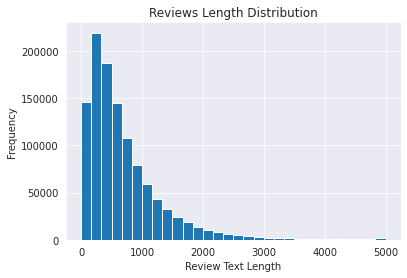

In [7]:
sns.set_style('darkgrid')
plt.hist(df.text_length,bins=30)
plt.xlabel('Review Text Length')
plt.ylabel('Frequency')
plt.title('Reviews Length Distribution')
plt.show()

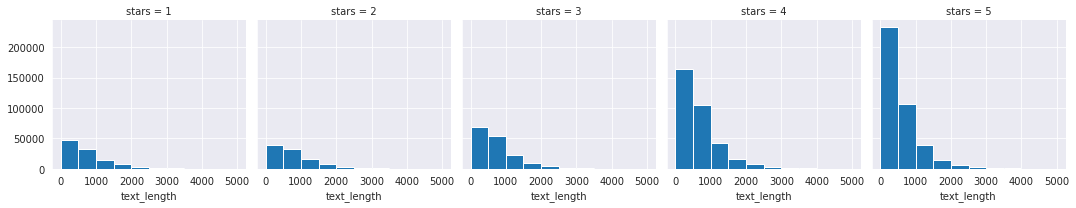

In [8]:
p = sns.FacetGrid(df, col='stars')
p.map(plt.hist, 'text_length')

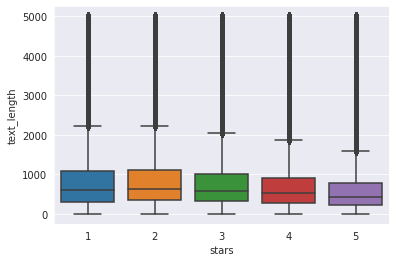

In [9]:
plt.figure(figsize=[6,4])
sns.boxplot('stars','text_length',data=df)

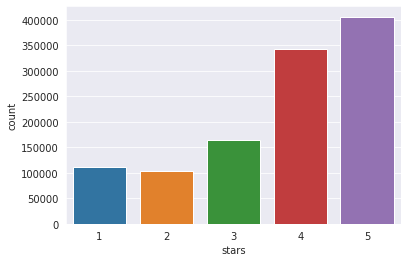

In [10]:
sns.countplot(df.stars)

In [11]:
stars = df.groupby('stars').mean()
stars

,votes.cool,votes.funny,votes.useful,text_length
stars,,,,
1,0.344184,0.659752,1.374788,831.750063
2,0.488665,0.634766,1.250942,840.016936
3,0.645960,0.568310,1.098406,766.250731
4,0.777403,0.534867,1.139316,692.317581
5,0.677868,0.434907,1.043825,598.010681


In [12]:
stars.corr()

,votes.cool,votes.funny,votes.useful,text_length
votes.cool,1.000000,-0.777084,-0.877753,-0.756324
votes.funny,-0.777084,1.000000,0.894475,0.983898
votes.useful,-0.877753,0.894475,1.000000,0.819646
text_length,-0.756324,0.983898,0.819646,1.000000


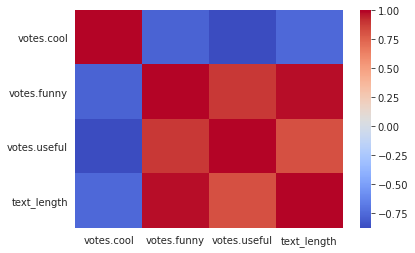

In [13]:
sns.heatmap(stars.corr(), cmap='coolwarm')

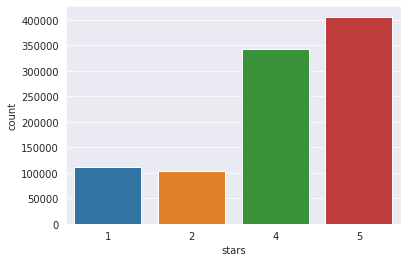

In [14]:
# for the model, ignore the neutral reviews
df = df[df.stars!=3]
sns.countplot(df.stars)

In [15]:
# partition the reviews into positive and negative to perform binary sentiment analysis
df.loc[:,'sentiment'] = df.stars.apply(lambda x: 1 if x>3 else 0)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


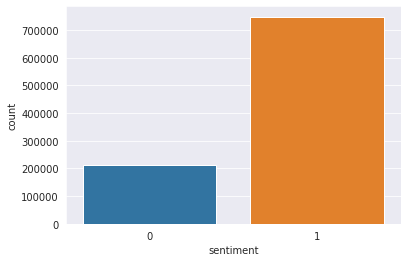

In [16]:
sns.countplot(df.sentiment)

In [17]:
# Want to train the model with similar number of positive and negative reviews, so for better balance ignoring reviews that are too long as way to reduce positive reviews and decrease bias
#df = df[(df['sentiment']==1) & (df['text_length']<750) | (df['sentiment']==0)]

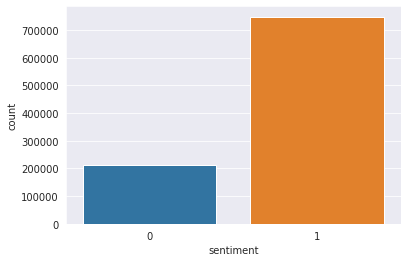

In [18]:
sns.countplot(df.sentiment)

In [19]:
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

# remove punctuation and stopwords
def clean_text(text):
    rem_punc = ''.join([char for char in text if char not in string.punctuation])
    rem_stop = [word for word in rem_punc.split() if word.lower() not in stopwords.words('english')]
    return rem_stop

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
# Count Vectorization
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(analyzer=clean_text)
review_vec = count_vec.fit_transform(df.text)

In [21]:
review_vec.shape

(961697, 683980)

## Training the Model

In [22]:
# Intialize X and y values for the model
X = review_vec
y = df.sentiment.values

In [23]:
print(X.shape)
print(y.shape)

(961697, 683980)
(961697,)


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

[[ 25097   6929]
 [  7317 104912]]
              precision    recall  f1-score   support

           0       0.77      0.78      0.78     32026
           1       0.94      0.93      0.94    112229

    accuracy                           0.90    144255
   macro avg       0.86      0.86      0.86    144255
weighted avg       0.90      0.90      0.90    144255

Score: 90.12


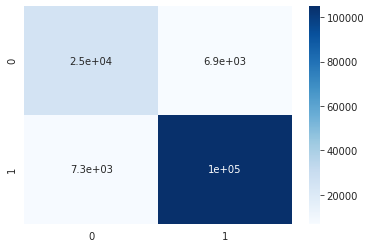

In [25]:
# Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
# model evalualtion
y_pred = nb_classifier.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
print(cm)
print(classification_report(y_test, y_pred))
print("Score:",round(accuracy_score(y_test,y_pred)*100,2))

In [26]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
logr = LogisticRegression()
parameters = {'max_iter':[1000,10000,100000]}
clf = GridSearchCV(logr, parameters, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'max_iter': [1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

0.9433488864860078 {'max_iter': 1000} LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[ 26975   5051]
 [  3019 109210]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     32026
           1       0.96      0.97      0.96    112229

    accuracy                           0.94    144255
   macro avg       0.93      0.91      0.92    144255
weighted avg       0.94      0.94      0.94    144255

Score: 94.41


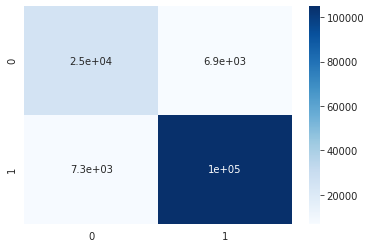

In [27]:
print(clf.best_score_, clf.best_params_, clf.best_estimator_)
y_pred = clf.predict(X_test)
sns.heatmap(cm, annot=True, cmap='Blues')
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))
print("Score:",round(accuracy_score(y_test,y_pred)*100,2))

In [ ]:
# # MULTILAYER PERCEPTRON CLASSIFIER
# from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier()
# mlp.fit(X_train,y_train)
# y_pred = mlp.predict(X_test)
# print("Confusion Matrix for Multilayer Perceptron Classifier:")
# print(confusion_matrix(y_test,y_pred))
# print("Classification Report:")
# print(classification_report(y_test,predmlp))
# print("Score:",round(accuracy_score(y_test,y_pred)*100,2))

In [ ]:
# # Random Forest Classifier
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# y_pred = rf.predict(X_test)
# cm = confusion_matrix(y_test,y_pred)
# sns.heatmap(cm, annot=True, cmap='Blues')
# print(cm)
# print(classification_report(y_test, y_pred))
# print("Score:",round(accuracy_score(y_test,y_pred)*100,2))